# Driver Drowsiness Detection System

Studies indicate that fatigue-related crashes account for about 20% of road accidents and even more on roads with no driving hour regulations. Driver detection systems, particularly those focusing on drowsiness detection, aim to address that alarming rate by monitoring drivers for signs of drowsiness and issuing timely alerts to prevent potential crashes.

For our final project, we chose to develop a DDS that will utilize two convolutional neural networks (CNNs). One will be trained on the [UTA Dataset](https://www.kaggle.com/datasets/rishab260/uta-reallife-drowsiness-dataset) (comprised of drowsy/neutral/alert driver images), and the other on [Behavioral Drowsiness Dataset](https://www.kaggle.com/datasets/dheerajperumandla/drowsiness-dataset) (containing images of closed/open eyes, and yawning/not yawning drivers). Both model's predictions will be layer combined to output the final result on the webcam (but evaluated separately on the testing data)l the combined model will then provide alerts based on the detected level of fatigue in real time. 

*Datasets need to be downloaded and stored in the root directory - frames from the UTA dataset have been extracted by us separately, through [code available on Kaggle](https://www.kaggle.com/code/jmash12/film-to-frames), while the behavioral drowsiness dataset is ready to be integrated once unzipped.*
*To perform behavioral signs analysis, [Frontalface Cascade](https://www.kaggle.com/datasets/timlukasblom/haarcascade-frontalface-defaultxml) has to be downloaded.*

### Requirements 
- TensorFlow: Developed by the Google Brain team for machine learning and artificial intelligence, Tensorflow has a allows for training and inference of deep neural networks.

- Keras: Provides a Python interface for artificial neural networks (inbuilt python library).

- Numpy: Used for scientific computing in Python. Provides support for arrays, matrices, and various mathematical functions to operate on them. 

- OpenCV: Machine learning and compiter vision library; contains >2500 algorhitms optimized for various CV tasks; allows for webcam access.

- Scikit-learn: Data mining, data analysis. In this project, used for splitting datasets. 

- Pandas: Data manipulation and analysis library. Used to create dataframes associating frames with their labels.

- Kagglehub: For downloading Kaggle datasets 

- Visualkeras: For network visualization


In [213]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import cv2
import os
import kagglehub
import visualkeras
from tensorflow.keras import regularizers


In [206]:
# PRESETS 
# Current working directory 
working_dir = os.getcwd()
# UTA DD Dataset directory (frames = participant_02_vid...)
uta_dir = working_dir + '/frames' 
# Behavioral Signs Dataset directory (behavioral_signs_frames = closed, open, yawn, no_yawn)
behavior_dir = working_dir + '/behavioral_signs_frames'
# OpenCV cascade for face detection
face_cascade_path = working_dir + '/haarcascade_frontalface_default.xml'
# Image size for VGG16
IMG_SIZE = 224 
# Initializing face cascade (will be used to detect faces in the images)
face_cascade = cv2.CascadeClassifier(face_cascade_path)

## Frame - Class (Label) Association
### Appending Labels for the UTA Dataset 
Frames captured are associated with **not drowsy, neutral, and drowsy classes**, based on the 'vid' label within the parsed filename. They're later saved to a pandas dataframe for training, validating, and testing.

In [207]:
def parse_filename(filename):
    parts = filename.split('_')
    for i, part in enumerate(parts):
        if part.lower() == 'vid':
            label = int(parts[i + 1])
            if label == 0:
                return 'not_drowsy'
            elif label == 5:
                return 'neutral'
            elif label == 10:
                return 'drowsy'
            else:
                return None
    return None

In [209]:
# Function to process the images. 
def create_dataframe(image_dir):
    data = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.endswith('.jpg'):
                label = parse_filename(file)
                if label:
                    data.append((os.path.join(root, file), label))
    return pd.DataFrame(data, columns=['filepath', 'label'])

df_drowsiness = create_dataframe(working_dir)

# Sanity check
df_drowsiness.sample(5)

,filepath,label
104,/Users/zdzilowska/Desktop/ANN final/frames/Par...,drowsy
454,/Users/zdzilowska/Desktop/ANN final/frames/Par...,not_drowsy
16,/Users/zdzilowska/Desktop/ANN final/frames/Par...,not_drowsy
613,/Users/zdzilowska/Desktop/ANN final/frames/Par...,neutral
649,/Users/zdzilowska/Desktop/ANN final/frames/Par...,drowsy


### Appending Labels for the Behavioral Signs Dataset
To adjust the complexity of our final (combined) model, we will train a second CNN that utilizes the Behavioral Signs Dataset. The behavioral_signs_frames folder contains labeled images of open and closed eyes, as well as yawning and non-yawning drivers. This added data will significantly enhance the model's ability to generalize, addressing the overfitting issue encountered when using only the UTA dataset frames in our initial model. Will be used for webcam real-time analysis. 

In [185]:
label_map = {'closed': 0, 'open': 1, 'no_yawn': 2, 'yawn': 3}

# Function to preprocess images and detect faces from the behavioral signs dataset. Returns a DataFrame with the processed data.
def extract_features_behavior(image_dir, face_cascade_path, label_map):
    data = []
    # No need to extract faces in the case of 'open' and 'closed' labels
    for label in os.listdir(image_dir):
        # Constructing the path to the label folder 
        label_folder_path = os.path.join(image_dir, label)
        if label in ['open', 'closed']:  
            if os.path.isdir(label_folder_path):
                for image_name in os.listdir(label_folder_path):
                    img_array = cv2.imread(os.path.join(label_folder_path, image_name), cv2.IMREAD_COLOR)
                    array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    data.append([array, label_map[label]])
        else: # if label is 'yawn' or 'no_yawn'
            if os.path.isdir(label_folder_path):
                for image_name in os.listdir(label_folder_path):
                    image_path = os.path.join(label_folder_path, image_name)

                    # Load the image, skip if invalid
                    img = cv2.imread(image_path)
                    if img is None:
                        continue 

                    # Convert to grayscale (required for face detection)
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

                    # If a face is detected, crop and resize the face
                    for (x, y, w, h) in faces:
                        face = img[y:y+h, x:x+w]  # Cropping the face
                        resized_face = cv2.resize(face, (IMG_SIZE, IMG_SIZE)) 
                        behavior_label = label_map[label]
                        data.append([resized_face, behavior_label])
    return pd.DataFrame(data, columns=['features', 'behavior_label'])

# Create the DataFrame with face detection and preprocessing
df_behavior = extract_features_behavior(behavior_dir, face_cascade_path, label_map) # Has shape (224, 224, 3)

# Sanity check 
df_behavior.sample(5)

,features,behavior_label
1418,"[[[120, 135, 168], [120, 135, 168], [120, 135,...",1
104,"[[[111, 114, 105], [113, 114, 105], [116, 117,...",0
356,"[[[132, 139, 154], [136, 142, 157], [138, 143,...",0
1756,"[[[74, 119, 176], [75, 120, 177], [76, 121, 17...",1
1646,"[[[187, 200, 232], [188, 201, 233], [190, 203,...",1


## Data Preparation and Augmentation 
### UTA Model
The dataset is split into training, validation, and testing sets. The frames are then rescaled, as well as augmented for the training dataset to increase the variety of data.

In [211]:
# Initialization of the train, validation, and test datasets extracted from the UTA RealLife Drowsiness Dataset. 
train_val_df, test_df = train_test_split(df_drowsiness, test_size=0.2, stratify=df_drowsiness['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, stratify=train_val_df['label'], random_state=42)

train_datagen = ImageDataGenerator(rescale=0.2)
val_datagen = ImageDataGenerator(rescale=0.2)
test_datagen = ImageDataGenerator(rescale=0.2)

# Artificially increases size of the training dataset; ensures a wider range of imgs. 
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 543 validated image filenames belonging to 3 classes.
Found 181 validated image filenames belonging to 3 classes.
Found 182 validated image filenames belonging to 3 classes.


### Behavioral Model
The behavioral model is split into datasets as the UTA model, with the features converted into numPy arrays to match the expected network input. 

In [ ]:
# Splitting the data into features and labels
X = np.stack(df_behavior['features'].values)  # Converting features to a numpy array. Will have shape (tot_imgs, 224, 224, 3)
y = np.array(df_behavior['behavior_label'].values) # Converting labels to an array. Will have shape (tot_imgs,)

# Splitting into train, validation, and test sets.
X_train_beh, X_test_beh, y_train_beh, y_test_beh = train_test_split(X, y, random_state=42, test_size=0.3)

# Data augmentation for improved generalization
train_behavioral = ImageDataGenerator(
    rescale=1/255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
)
test_behavioral = ImageDataGenerator(rescale=1/255)

# Setting the batch size for improved generalization
train_behavioral = train_behavioral.flow(np.array(X_train_beh), y_train_beh, shuffle=False)
test_behavioral = test_behavioral.flow(np.array(X_test_beh), y_test_beh, shuffle=False)

## Model Definition, Compilation, and Training
### UTA Model D, C & T 
The model architecture is defined using a pre-trained (on ImageNet) VGG16 base model. The top layers are excluded and the input shape is specified to match the dimensions of our input data. Custom layers are then added for the 3-class classification. To prevent the weights of the pre-trained VGG16 base model from being updated during training, we freeze all the layers of the base model, after which the model is compiled, and trained using the training and validation datasets. 

In [217]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(x)  # 3 classes: 0 - not_drowsy, 5 - drowsy, 10 - neutral

model = Model(inputs=base_model.input, outputs=predictions)

# The base is freezed
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# ! Actual training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5
)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step - accuracy: 0.7713 - loss: 3.0603 - val_accuracy: 0.9766 - val_loss: 0.7095
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9375 - loss: 1.6377 - val_accuracy: 1.0000 - val_loss: 0.4963
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.9819 - loss: 0.7032 - val_accuracy: 1.0000 - val_loss: 0.4878
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 1.0000 - loss: 0.4878 - val_accuracy: 1.0000 - val_loss: 0.4868
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.9993 - loss: 0.5101 - val_accuracy: 1.0000 - val_loss: 0.4785


In [226]:
model.save_weights('drowsiness_weights.weights.h5')

### Behavioral Model D, C & T
The model is designed to classify images into yawning, not yawning, open eyes, and closed eyes categories. The model uses **convolutional layers** which help to learn spatial features in the images (higher num of filters in initial layers captures low-level edges and textures, while the decreasing spatial dimension deeper in the network captures more abstract features). **MaxPooling** reduces the spatial dimensions of the images (-> model focuses on the most important features), **dropout** helps prevent overfitting, and the final **softmax** layer outputs the probabilities for each of the four classes. Sparse categorical crossentropy automatically handles integers ranging from [0,3] to convert them to a one-hot encoded format. 
The class with the highest probability is the predicted label.

In [ ]:
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=X_train_beh.shape[1:])
vgg16_base.trainable = False

model_beh = Sequential([
    vgg16_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_beh.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Since s_c_c automatically one-hot encodes the 4 labels
    metrics=['accuracy']
)

history_beh = model_beh.fit(
    train_behavioral,
    validation_data=test_behavioral,
    epochs=20,
    shuffle=True,
)

/Users/zdzilowska/miniconda3/envs/dis/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 419s 10s/step - accuracy: 0.5199 - loss: 1.4581 - val_accuracy: 0.8028 - val_loss: 0.4419
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 412s 10s/step - accuracy: 0.7257 - loss: 0.6490 - val_accuracy: 0.8131 - val_loss: 0.3986
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 420s 10s/step - accuracy: 0.7502 - loss: 0.5286 - val_accuracy: 0.8028 - val_loss: 0.3876
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 397s 9s/step - accuracy: 0.7874 - loss: 0.4814 - val_accuracy: 0.7855 - val_loss: 0.3740
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 451s 10s/step - accuracy: 0.8089 - loss: 0.4605 - val_accuracy: 0.8304 - val_loss: 0.3372
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 459s 11s/step - accuracy: 0.7940 - loss: 0.4519 - val_accuracy: 0.9273 - val_loss: 0.2329
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 421s 10s/step - accuracy: 0.8281 - loss: 0.3872 - val_accuracy: 0.8581 - val_loss: 0.3173
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 436s 10s/step - accuracy: 0.8099 - loss: 0.4138 - val_accuracy: 0.8

In [188]:
model_beh.save_weights('behavioral_weights.weights.h5')

## Network Architecture 
### UTA Model Architecture

You must install pydot (`pip install pydot`) for `plot_model` to work.


/Users/zdzilowska/miniconda3/envs/dis/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


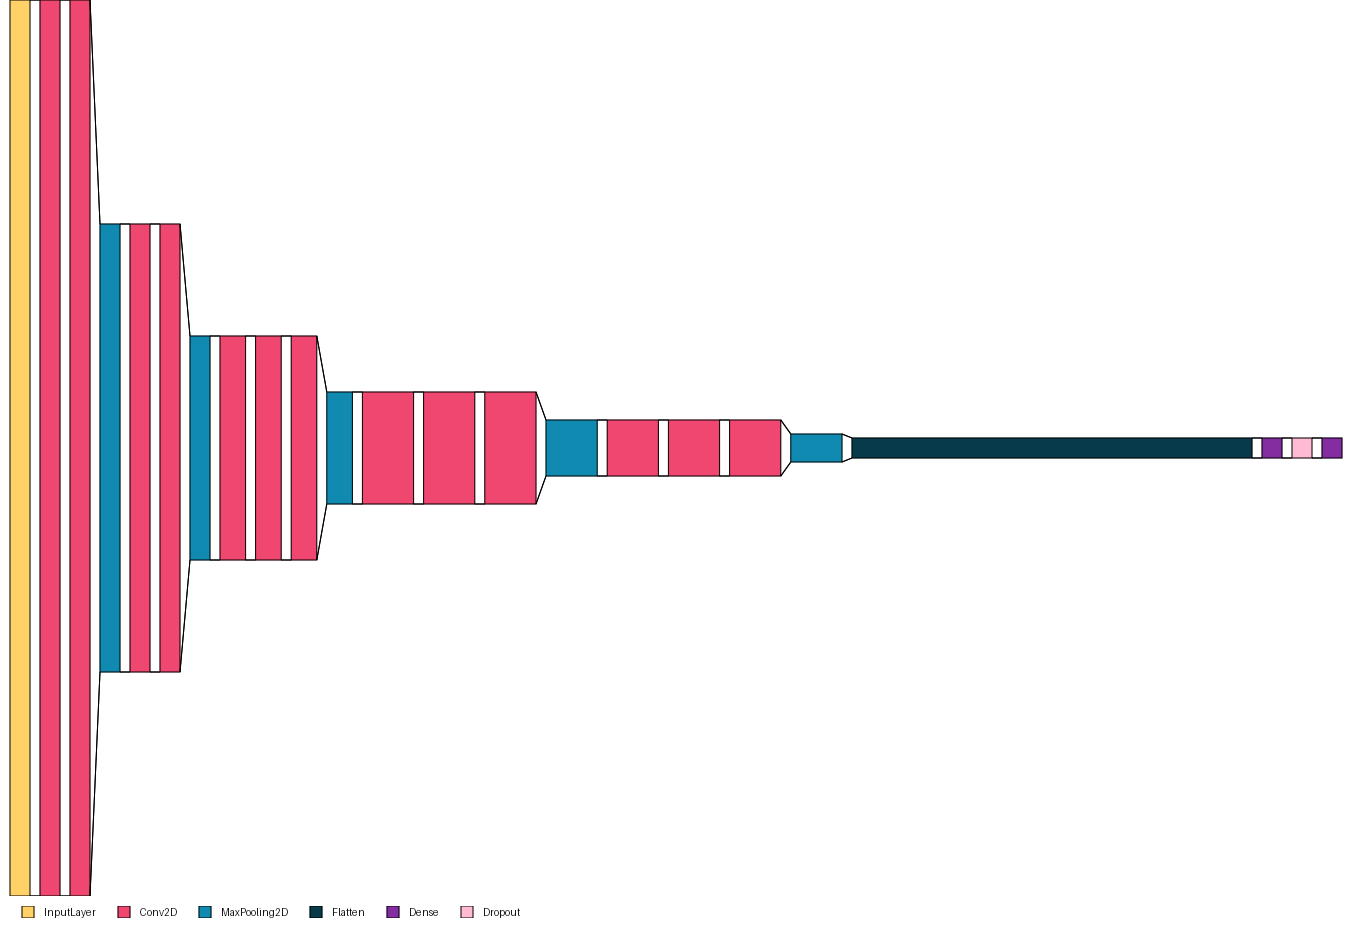

In [ ]:
plot_model(model, to_file='model_drowsiness.png', show_shapes=True, show_layer_names=True)
visualkeras.layered_view(model, legend=True, draw_volume=False)

### Behavioral Model Architecture

You must install pydot (`pip install pydot`) for `plot_model` to work.


/Users/zdzilowska/miniconda3/envs/dis/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


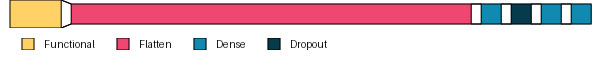

In [ ]:
plot_model(model_beh, to_file='model_behavioral.png', show_shapes=True, show_layer_names=True)
visualkeras.layered_view(model_beh, legend=True, draw_volume=False)

## Performance evaluation
### UTA Model Performance
With the accuracy surprisingly high, we've checked the appropriateness of labels (correct - the dataset is balanced; same amount of drowsy, neutral, and not drowsy images), and for potential data leakage issues (none - we've verified the integrity of train-test splits, all of the dataframe's feature column cells are unique).

/Users/zdzilowska/miniconda3/envs/dis/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.9953 - loss: 0.5329
Test loss: 0.542055070400238
Test accuracy: 0.9945054650306702


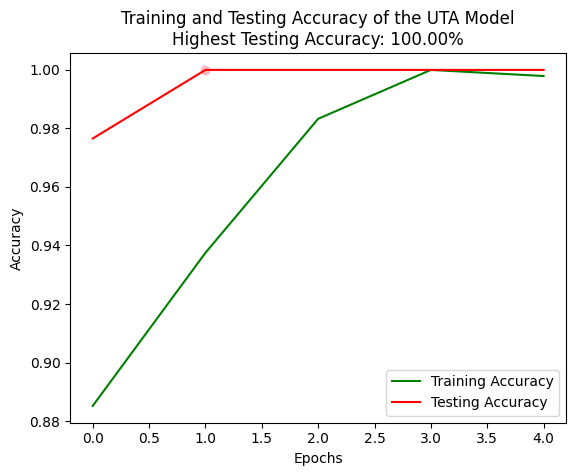

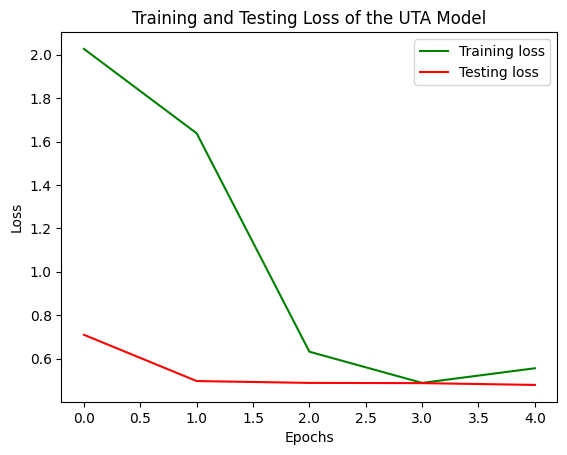

In [222]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

# Accuracy and loss plots
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Highest testing accuracy and its index
max_val_acc = max(val_accuracy)
min_val_acc = min(val_accuracy)
max_val_acc_index = val_accuracy.index(max_val_acc)
max_accuracy = max(accuracy)
min_loss = min(loss)
min_val_loss = min(val_loss)
plt.plot(max_val_acc_index, max_val_acc, marker='o', color='lightpink')

# Training and testing accuracy over epochs
plt.plot(epochs, accuracy, "g", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Testing Accuracy")
plt.legend()
plt.title("Training and Testing Accuracy of the UTA Model\nHighest Testing Accuracy: {:.2f}%".format(max_val_acc*100))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# Plotting loss over epochs
plt.plot(epochs, loss, "g", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Testing loss")
plt.legend()
plt.title("Training and Testing Loss of the UTA Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Behavioral CNN Performance

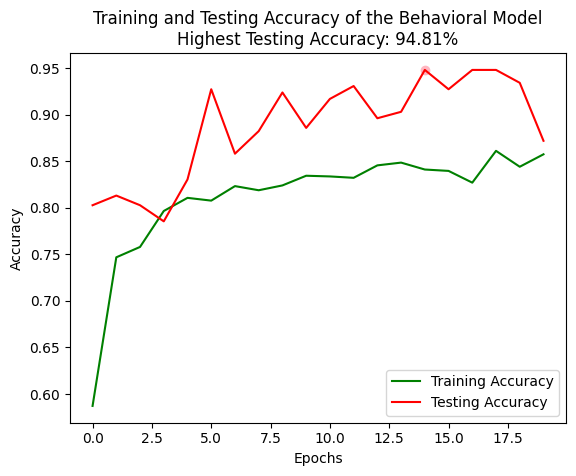

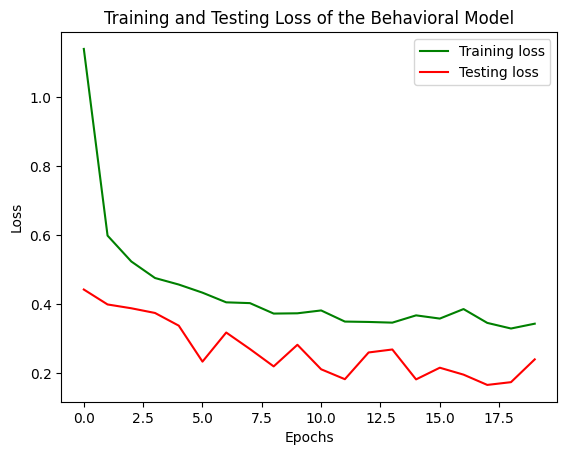

In [195]:
import matplotlib.pyplot as plt

accuracy = history_beh.history['accuracy']
val_accuracy = history_beh.history['val_accuracy']
loss = history_beh.history['loss']
val_loss = history_beh.history['val_loss']
epochs = range(len(accuracy))

max_val_acc = max(val_accuracy)
max_val_acc_index = val_accuracy.index(max_val_acc)
min_val_acc = min(val_accuracy)
max_accuracy = max(accuracy)
min_loss = min(loss)
min_val_loss = min(val_loss)
plt.plot(max_val_acc_index, max_val_acc, marker='o', color='lightpink')

plt.plot(epochs, accuracy, "g", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Testing Accuracy")
plt.legend()
plt.title("Training and Testing Accuracy of the Behavioral Model\nHighest Testing Accuracy: {:.2f}%".format(max_val_acc*100))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

plt.plot(epochs, loss, "g", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Testing loss")
plt.legend()
plt.title("Training and Testing Loss of the Behavioral Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### Real-Time Driver Drowsiness Detection 
Using the models defined above, we'll now implement a real-time DDS based on a webcam. The code captures live video frames using OpenCV, processes them to match the input requirements of the trained model, and performs predictions to determine drowsy vs alert state. The model's predictions are overlaid onto the video feed in real time, displaying the driver's status and confidence scores. 

*The system is interactive, allowing the user to view the annotated video feed and terminate the program by pressing the 'q' key.*

In [227]:
# Rebuilding both models to omit steps above, with the weights already generated
# -------------------------- Drowsiness Model --------------------------
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax', kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01))(x)  # 3 classes: 0 - not_drowsy, 5 - drowsy, 10 - neutral

model = Model(inputs=base_model.input, outputs=predictions)
# The base is freezed
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_drowsiness_path = "drowsiness_weights.weights.h5"
model.load_weights(model_drowsiness_path)
# -------------------------- Behavioral Model --------------------------
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=X_train_beh.shape[1:])
vgg16_base.trainable = False

model_beh = Sequential([
    vgg16_base,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

model_beh.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
)

model_behavior_path = "behavioral_weights.weights.h5"
model_beh.load_weights(model_behavior_path)

/Users/zdzilowska/miniconda3/envs/dis/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Configuration for alert system
consecutive_drowsy_frames = 5  # Num of consecutive "drowsy" frames to trigger alert
drowsy_counter = 0
map_labels = {0: 'not_drowsy', 1: 'neutral', 2: 'drowsy'}

# Defining the preprocessing function to match the model's input requirements. Returns a single adjusted frame. 
def preprocess_frame(frame, face_cascade=face_cascade):
  # Normalize 
  img = frame / 255
  # Resize to match the size used during training
  resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  # Reshape the image to match the input shape 
  return resized.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Starting the camera; 0 - default camera
cap = cv2.VideoCapture(0) 

print("Press 'q' to quit the webcam stream.")
while cap.isOpened():
  ret, frame = cap.read()  # Reading frame-by-frame
  if not ret:
    print("Failed to capture frame. Exiting...")
    break
  
  processed_frame = preprocess_frame(frame)

  # Making a prediction
  prediction_drowsy = model.predict(processed_frame)
  drowsy = np.argmax(prediction_drowsy) 
  drowsy_label = map_labels[drowsy]
  prediction_beh = model_beh.predict(processed_frame)
  beh_label = np.argmax(prediction_beh) # Index of the max value in the array of probabilities - max probability class
  print(prediction_beh)
  print(beh_label)

  # Combine predictions. Final status will be drowsy if 30 cons frames are drowsy (/closed/yawn)
  if drowsy_label == 'drowsy' and (beh_label in [1, 3]):  # must be drowsy and (closed eyes or yawning)
    drowsy_counter += 1
  else: 
    drowsy_counter = 0

  # Checking if alert conditions are met
  if drowsy_counter >= consecutive_drowsy_frames:
    status = "Drowsiness Detected"
    color = (0, 0, 255)  
  else :
    status = "No Drowsiness Detected"
    color = (0, 255, 0)

  # Annotating the frame
  cv2.putText(frame, f"Status: {status}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
  # Displaying the frame with annotations
  cv2.imshow("Drowsy Driver Detection", frame)

  # Breaking the loop once 'q' is pressed
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

cap.release()
cv2.destroyAllWindows()
print(f"Total frames processed: {frame_count}")

label_map = {'closed': 0, 'open': 1, 'no_yawn': 2, 'yawn': 3}



Press 'q' to quit the webcam stream.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
[[0.00164548 0.00596085 0.16358979 0.82880396]]
3
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
[[0.00196506 0.00857368 0.12372449 0.8657367 ]]
3
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
[[0.00254896 0.00950396 0.14904265 0.83890444]]
3
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
[[0.00206684 0.00769572 0.15597901 0.83425844]]
3
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
[[0.00405719 0.01124201 0.21403791 0.77066284]]
3
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
[[0.0444404  0.10222755 0.25412685 0.5992052 ]]
3
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
[[0.02158421 0.0721272  0.23706368 0.6692249 ]]
3
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━

NameError: name 'frame_count' is not defined